In [1]:
N_CLASSES = 43
RESIZED_IMAGE = (32,32) 

In [20]:
import matplotlib.pyplot as plt
import glob
from skimage.color import rgb2lab
from skimage.transform import resize
from collections import namedtuple
import numpy as np
np.random.seed(101)
%matplotlib inline

Dataset = namedtuple('Dataset',['X','y'])

def to_tf_format(imgs):
    return np.stack([img[:,:,np.newaxis] for img in imgs], axis=0).astype(np.float32)

    
def read_dataset_ppm(rootpath, n_labels, resize_to):
    images = []
    labels = []
    
    for c in range(n_labels):
        full_path = rootpath + '/' + format(c,'05d') + '/'
        
        for img_name in glob.glob(full_path + '*.ppm'):
            img = plt.imread(img_name).astype(np.float32) # 3 dims - rgb
            img = rgb2lab(img / 255.0)[:,:,0] # removes 3rd dimension
            
            
            if resize_to:
                img = resize(img, resize_to, mode='reflect')
                
            label = np.zeros((n_labels,),dtype=np.float32)
            label[c] = 1.0
            images.append(img.astype(np.float32))
            labels.append(label)
    
    print(np.array(labels).shape)
    print(np.array(images).shape)
    return Dataset(X=to_tf_format(images).astype(np.float32), y=np.array(labels).astype(np.float32))

dataset = read_dataset_ppm('GTSRB_Final_Training_Images/GTSRB/Final_Training/Images', N_CLASSES, RESIZED_IMAGE)

print(dataset.X.shape)
print(dataset.y.shape)

(39209, 43)
(39209, 32, 32)
(39209, 32, 32, 1)
(39209, 43)


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


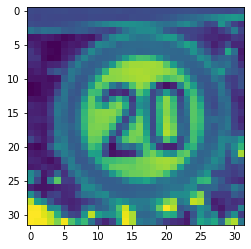

In [21]:
plt.imshow(dataset.X[1,:,:,:].reshape(RESIZED_IMAGE))
print(dataset.y[1,:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


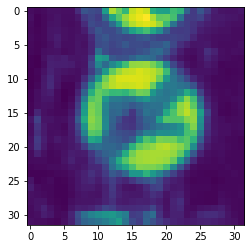

In [39]:
plt.imshow(dataset.X[-1,:,:,:].reshape(RESIZED_IMAGE))
print(dataset.y[-1,:])

In [40]:
from sklearn.model_selection import train_test_split

idx_train, idx_test = train_test_split(range(dataset.X.shape[0]), test_size=0.25)

X_train = dataset.X[idx_train,:,:]
X_test = dataset.X[idx_test,:,:]
y_train = dataset.y[idx_train,:]
y_test = dataset.y[idx_test,:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(29406, 32, 32, 1)
(9803, 32, 32, 1)
(29406, 43)
(9803, 43)


In [41]:
# Creating minibatches of training data

n_samples = X_train.shape[0]

def minibatcher(X, y, batch_size, shuffle):
    assert X.shape[0] == y.shape[0]
    
    if shuffle:
        idx = np.random.permutation(n_samples)
    else:
        idx = list(range(n_samples))
    for k in range(int(np.ceil(n_samples/batch_size))):
        from_idx = k * batch_size
        to_idx = (k+1) * batch_size
        yield X[idx[from_idx:to_idx],:,:,:], y[idx[from_idx:to_idx],:]
        

for mb in minibatcher(X_train, y_train, 10000, True):
    print(mb[0].shape, mb[1].shape)

(10000, 32, 32, 1) (10000, 43)
(10000, 32, 32, 1) (10000, 43)
(9406, 32, 32, 1) (9406, 43)


In [42]:
import tensorflow as tf

def tf_no_activation_layer(in_tensors, n_units):
    w = tf.compat.v1.get_variable(name='fc_W',
                       shape=[in_tensors.get_shape()[1],n_units],
                       dtype=tf.float32,
                       initializer=tf.keras.initializers.glorot_normal())
    b = tf.compat.v1.get_variable(name='fc_B',
                       shape=[n_units,],
                       dtype=tf.float32,
                       initializer=tf.constant_initializer(0.0))
    return tf.matmul(in_tensors, w) + b

In [43]:
def fc_layer(in_tensors, n_units):
    return tf.nn.leaky_relu(tf_no_activation_layer(in_tensors, n_units))

In [44]:
def conv_layer(in_tensors, kernel_size, n_units):
    w = tf.compat.v1.get_variable(name='conv_W',
                       shape=[kernel_size, kernel_size, in_tensors.shape[3], n_units],
                       dtype=tf.float32,
                       initializer=tf.keras.initializers.glorot_normal())
    b = tf.compat.v1.get_variable(name='conv_B',
                       shape=[n_units,],
                       dtype=tf.float32,
                       initializer=tf.constant_initializer(0.0))
    return tf.nn.leaky_relu(tf.nn.conv2d(input=in_tensors, filters=w, strides=[1,1,1,1], padding='SAME') + b)

In [45]:
def maxpool_layer(in_tensors, sampling):
    return tf.nn.max_pool(in_tensors, [1, sampling, sampling, 1], [1, sampling, sampling, 1], 'SAME')

In [46]:
def dropout(in_tensors, keep_proba, is_training):
    return tf.cond(is_training, lambda: tf.nn.dropout(in_tensors, keep_proba), lambda: in_tensors)

In [60]:
def model(in_tensors, is_training):
    
    # First layer: 5x5 2d-conv, 32 filters, 2x maxpool, 20% drouput
    with tf.variable_scope('l1', reuse=tf.AUTO_REUSE):
        l1 = maxpool_layer(conv_layer(in_tensors, 5, 32), 2)
        l1_out = dropout(l1, 0.8, is_training)
        #print(l1_out)
    
    # Second layer: 5x5 2d-conv, 64 filters, 2x maxpool, 20% drouput
    with tf.variable_scope('l2', reuse=tf.AUTO_REUSE):
        l2 = maxpool_layer(conv_layer(in_tensors, 5, 64), 2)
        l2_out = dropout(l2, 0.8, is_training)
        #print(l2_out)
        
    with tf.variable_scope('flatten', reuse=tf.AUTO_REUSE):
        l2_out_flat = tf.compat.v1.layers.flatten(l2_out)
        #print(l2_out_flat.shape)
        
    # Fully collected layer, 1024 neurons, 40% dropout
    with tf.variable_scope('l3', reuse=tf.AUTO_REUSE):
        l3 = fc_layer(l2_out_flat, 1024)
        #print(l3)
        l3_out = dropout(l3, 0.6, is_training)
        
    # Output
    with tf.variable_scope('out', reuse=tf.AUTO_REUSE):
        out_tensors = tf_no_activation_layer(l3_out, N_CLASSES)
        
    return out_tensors

In [63]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def train_model(X_train, y_train, X_test, y_test, learning_rate, max_epochs, batch_size):
    #tf.enable_eager_execution()
    in_X_tensors_batch = tf.placeholder(tf.float32, shape=(None, RESIZED_IMAGE[0], RESIZED_IMAGE[1], 1))
    in_y_tensors_batch = tf.placeholder(tf.float32, shape=(None, N_CLASSES))
    is_training = tf.placeholder(tf.bool)
    
    #in_X_tensors_batch = tf.Variable(tf.zeros(shape=(RESIZED_IMAGE[0],RESIZED_IMAGE[1], 1))[None,:,:,:])
    #print(in_X_tensors_batch)
    #in_y_tensors_batch = tf.Variable(tf.zeros(shape=(N_CLASSES))[None,:])
    #print(in_y_tensors_batch)
    #is_training = True
    
    logits = model(in_X_tensors_batch, is_training)
    out_y_pred = tf.nn.softmax(logits)
    loss_score = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=in_y_tensors_batch)
    loss = tf.reduce_mean(loss_score)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    with tf.compat.v1.Session() as session:
        session.run(tf.global_variables_initializer())
        for epoch in range(max_epochs):
            print("Epoch=", epoch)
            tf_score = []
            
            for mb in minibatcher(X_train, y_train, batch_size, shuffle=True):
                tf_output = session.run([optimizer, loss],
                                       feed_dict={in_X_tensors_batch:mb[0],
                                                 in_y_tensors_batch:mb[1],
                                                 is_training:True})
                tf_score.append(tf_output[1])
            print("train_loss_score=",np.mean(tf_score))
            
        print("TEST SET PERFORMANCE")
        y_test_pred, test_loss = session.run([out_y_pred, loss],
                                            feed_dict={in_X_tensors_batch:X_test,
                                                      in_y_tensors_batch:y_test,
                                                      is_training:False})
        
        print(" test_loss_score=", test_loss)
        y_test_pred_classified = np.argmax(y_test_pred, axis=1).astype(np.int32)
        y_test_true_classified = np.argmax(y_test, axis=1).astype(np.int32)
        print(classification_report(y_test_true_classified, y_test_pred_classified))
        cm = confusion_matrix(y_test_true_classified, y_test_pred_classified)
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.colorbar()
        plt.tight_layout()
        plt.show()
        # And the log2 version, to enphasize the misclassifications
        plt.imshow(np.log2(cm + 1), interpolation='nearest', cmap=plt.get_cmap("tab20"))
        plt.colorbar()
        plt.tight_layout()
        plt.show()
        
tf.compat.v1.reset_default_graph()

/tmp/ipykernel_5076/3012722889.py:16: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  l2_out_flat = tf.compat.v1.layers.flatten(l2_out)


Epoch= 0
train_loss_score= 8.22398
Epoch= 1
train_loss_score= 0.75492555
Epoch= 2
train_loss_score= 0.4979733
Epoch= 3
train_loss_score= 0.35807505
Epoch= 4
train_loss_score= 0.30108616
Epoch= 5
train_loss_score= 0.24204269
Epoch= 6
train_loss_score= 0.19051673
Epoch= 7
train_loss_score= 0.19227247
Epoch= 8
train_loss_score= 0.14815341
Epoch= 9
train_loss_score= 0.1493389
TEST SET PERFORMANCE
 test_loss_score= 0.1622456
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        67
           1       0.91      0.99      0.95       539
           2       0.96      0.96      0.96       558
           3       0.95      0.93      0.94       364
           4       0.99      0.97      0.98       487
           5       0.95      0.96      0.96       479
           6       1.00      1.00      1.00       105
           7       0.95      0.99      0.97       364
           8       0.99      0.93      0.96       340
           9       0.98      0.99  

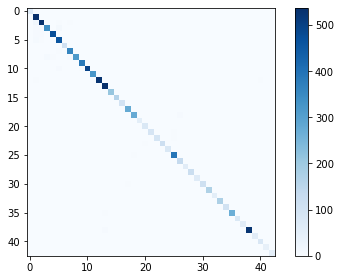

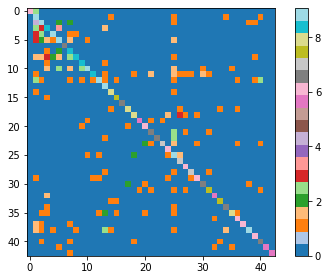

In [64]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
train_model(X_train, y_train, X_test, y_test, 0.001, 10, 256)